![](figs/se05.png)
# Workshop Instructions
***
- <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> Follow along by typing the code yourself - this helps with learning!
- <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> Code cells marked as "Exercise" are for you to complete
- <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> Look for hints if you get stuck
- <img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> Compare your solution with the provided answers
- <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> Don't worry if you make mistakes - debugging is part of learning!

In [2]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils
from torchvision import transforms
from PIL import Image
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(101)
torch.cuda.manual_seed(101)
random.seed(101)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

checker = utils.core.ExerciseChecker("SE05")
quizzer = utils.core.QuizManager("SE05")

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 0.9.5
Using device: cuda


# 1. Introduction to Transfer Learning
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Transfer learning is a machine learning technique where a model developed for one task is reused as a starting point for a model on a second task. It's particularly effective for deep learning models, as it allows us to leverage pre-trained models' knowledge rather than starting from scratch.

In previous sessions, we learned how to build and train neural networks from scratch. However, training large deep learning models requires:

1. **Massive datasets** (often millions of examples)
2. **Extensive computational resources** (often multiple GPUs)
3. **Long training times** (days to weeks)

Transfer learning addresses these challenges by letting us capitalise on existing models that have already been trained on large datasets.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <!-- Suggestion: Create and add an image showing transfer learning concept with knowledge flowing from source to target domain -->
    <img src="figs/transfer.png" alt="Transfer Learning Concept" style="width: 50%; height: auto; margin: 0 auto;">
</figure>

Transfer learning is inspired by human learning. Consider how we learn:

| Human Learning | Machine Learning Parallel |
|----------------|--------------------------|
| A child learns to recognize basic shapes before identifying letters | A model learns edge detection before specific object recognition |
| A musician who knows piano can learn guitar faster than a novice | A model trained on one image dataset can adapt quickly to a similar task |
| Language skills transfer across related languages (e.g., Spanish to Italian) | NLP models pre-trained on one language can be fine-tuned for another |

This mirrors how neural networks learn hierarchical features. Early layers learn general patterns that are often applicable across domains, while later layers learn task-specific features.

Transfer learning is particularly effective in computer vision and natural language processing (NLP) tasks, where large pre-trained models are available. The key advntages of transfer learning include:

| Advantage | Description |
|-----------|-------------|
| **Reduced Training Time** | Start with pre-learned features instead of random weights |
| **Less Training Data** | Leverage knowledge from the source domain |
| **Better Performance** | Often achieves higher accuracy than training from scratch |
| **Faster Convergence** | Models typically reach optimal performance in fewer epochs |
| **Lower Computational Cost** | Requires fewer resources for training |
| **Knowledge Retention** | Preserves useful features learned from large datasets |

## 1.2 When to Use Transfer Learning
***

Transfer learning is particularly useful when:

1. You have **limited training data** for your specific task
2. The pre-trained model was trained on a **similar domain** to your target task
3. You need to **accelerate model development**
4. You have **limited computational resources**
5. You want to **avoid overfitting** on small datasets

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Key Insight**: The effectiveness of transfer learning depends on the similarity between the source and target domains. The more similar they are, the more beneficial transfer learning becomes.




In [13]:
# Quiz on Transfer Learning Concepts
print("\n🧠 Quiz 1: Transfer Learning Applications")
quizzer.run_quiz(1)


🧠 Quiz 1: Transfer Learning Applications
--------------------------------------------------------------------------------
📋 Transfer Learning Applications Quiz
--------------------------------------------------------------------------------
In which engineering scenario would transfer learning provide the MOST significant advantage?

A. When you have a simple classification problem with millions of labeled examples
B. When you need to detect defects in industrial parts but only have 200 labeled images
C. When you're building a model to predict well-documented physical properties
D. When computational efficiency isn't a concern and you have months to train a model from scratch

❌ Error running quiz: 'correct'


# 2. Case Study: Plant leaf detection
***

In this section, we'll apply transfer learning to a real-world task: classifying mango leaves. This case study demonstrates how transfer learning can be effectively used in agricultural applications to identify plant characteristics.

In [4]:
data_path = Path.cwd() / 'datasets'
dataset_path = utils.data.download_dataset('mango leaves',
                                   dest_path=data_path,
                                   extract=True)
dataset_path = dataset_path / 'Root' / 'Original'

Downloading:
MangoLeafBD: A comprehensive image dataset to classify diseased and healthy mango leaves
> Authors: Sarder Iftekhar Ahmed, Muhammad Ibrahim, Md. Nadim
> Year: 2023
> Website: https://www.sciencedirect.com/science/article/pii/S2352340923000598

File already exists


Extracting Root.zip: 100%|██████████| 13428/13428 [00:08<00:00, 1649.09it/s]


Total number of images: 837
Amrapali Mango: 120 images
Banana Mango: 167 images
Chaunsa Mango: 150 images
Fazli Mango: 160 images
Haribhanga Mango: 120 images
Himsagar Mango: 120 images
Image category: Fazli Mango
Image size: (640, 480)


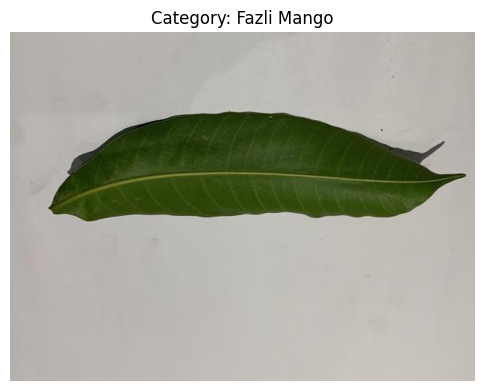

In [ ]:
# List all image files in the dataset
images = list(dataset_path.rglob('*.jpg'))
print(f"Total number of images: {len(images)}")

# Count images in each category
categories = {}
for img_path in images:
    category = img_path.parent.name
    if category not in categories:
        categories[category] = 0
    categories[category] += 1

# Display category distribution
for category, count in categories.items():
    print(f"{category}: {count} images")

# Visualize a random image from the dataset
rnd_img = random.choice(images)
img = Image.open(rnd_img)
print(f"Image size: {img.size}")

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Category: {rnd_img.parent.name}")
plt.axis('off')
plt.show()

## 3.4 Data Preparation
***

Now, let's prepare our data for training. We'll use the `ImageFolder` class from torchvision to load the images and apply transformations.

In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define transformations for training
ts = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

# Load the dataset
ds = ImageFolder(dataset_path, transform=ts)
print("Class labels:")
print(ds.classes)

# Display class-to-idx mapping
print("\nClass to index mapping:")
for class_name, idx in ds.class_to_idx.items():
    print(f"{class_name}: {idx}")

Class labels:
['Amrapali Mango', 'Banana Mango', 'Chaunsa Mango', 'Fazli Mango', 'Haribhanga Mango', 'Himsagar Mango']

Class to index mapping:
Amrapali Mango: 0
Banana Mango: 1
Chaunsa Mango: 2
Fazli Mango: 3
Haribhanga Mango: 4
Himsagar Mango: 5


In [9]:
# Split the dataset into training, validation, and test sets
train_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [0.7, 0.15, 0.15])
print(f"Training set size: {len(train_ds)}")
print(f"Validation set size: {len(val_ds)}")
print(f"Test set size: {len(test_ds)}")

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

Training set size: 586
Validation set size: 126
Test set size: 125


## 3.3 Building a Baseline Model
***

Before applying transfer learning, let's create a simple CNN model to serve as our baseline. This will help us appreciate the benefits of transfer learning.

In [7]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(32 * 56 * 56, 6)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        return x

### 1.3 The Transfer Learning Process
***

The transfer learning process typically involves these steps:

1. **Select a pre-trained source model** relevant to your target task
2. **Remove task-specific layers** (usually the final classification layers)
3. **Add new task-specific layers** appropriate for your target task
4. **Freeze some or all** of the pre-trained layers
5. **Train the model** on your target dataset
6. **Fine-tune** additional layers if needed

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <!-- Suggestion: Create and add an image showing the transfer learning process steps -->
    <img src="figs/transfer_learning_process.png" alt="Transfer Learning Process" style="width: 80%; height: auto; margin: 0 auto;">
    <figcaption>The transfer learning process: from source to target domain</figcaption>
</figure>

## 1.4 Common Pre-trained Models
***

Several pre-trained models are available in frameworks like PyTorch's `torchvision` library. These models are typically trained on the ImageNet dataset, which contains over 1.2 million images across 1,000 classes.

| Model | Year | Size | Top-1 Accuracy | Characteristics |
|-------|------|------|---------------|-----------------|
| **ResNet** | 2015 | 18-152 layers | 79.1% | Residual connections to solve vanishing gradient problem |
| **VGG** | 2014 | 16-19 layers | 74.5% | Simple architecture with 3×3 convolutions |
| **Inception** | 2014 | 22 layers | 78.0% | Parallel convolutions with different kernel sizes |
| **EfficientNet** | 2019 | Varies | 84.5% | Optimized architecture using neural architecture search |
| **MobileNet** | 2017 | Lightweight | 71.9% | Designed for mobile and embedded devices |
| **DenseNet** | 2017 | 121-201 layers | 77.3% | Each layer connected to every other layer |
| **Vision Transformer (ViT)** | 2020 | Base-Huge | 88.5% | Attention-based model for image classification |
| **ConvNeXt** | 2022 | Tiny-XL | 87.8% | Modern CNN architecture inspired by transformers |

For this workshop, we'll focus on using EfficientNet and ResNet, which offer excellent balances between accuracy and model size.

> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 1**: Loading Pre-trained Models in PyTorch
```python
import torchvision.models as models
import torch.nn as nn

# ResNet-50
resnet = models.resnet50(weights='IMAGENET1K_V1')

# EfficientNet-B0
efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')

# VGG-16
vgg = models.vgg16(weights='IMAGENET1K_V1')

# MobileNet V2
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')
```

# 2. Approaches to Transfer Learning
***

There are several approaches to transfer learning in deep neural networks. The two primary methods are:

1. **Feature Extraction**: Using the pre-trained network as a fixed feature extractor
2. **Fine-Tuning**: Further training the pre-trained network on the new task

Let's explore each of these approaches in detail.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <!-- Suggestion: Create and add an image showing feature extraction vs fine-tuning -->
    <img src="figs/feature_extraction_vs_finetuning.png" alt="Feature Extraction vs Fine-Tuning" style="width: 80%; height: auto; margin: 0 auto;">
    <figcaption>Feature extraction versus fine-tuning approaches</figcaption>
</figure>

## 2.1 Feature Extraction
***

> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Feature extraction involves using a pre-trained model to extract meaningful features from new samples, then training a new classifier on these features for the target task.

In feature extraction, we:

1. Take a pre-trained model and **freeze all layers** (weights won't be updated during training)
2. **Remove the final classification layer** (specific to the original task)
3. **Add new classification layers** appropriate for the new task
4. **Train only the new layers**, keeping the pre-trained layers fixed

This approach works well when the new dataset is small and similar to the original training data.

### Feature Hierarchy in Neural Networks

Neural networks learn hierarchical representations, where:
- **Early layers** detect basic features (edges, colors, textures)
- **Middle layers** detect more complex patterns (shapes, parts of objects)
- **Later layers** detect high-level concepts (whole objects, semantic concepts)

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <table style="margin: auto; border-collapse: collapse; width: 80%;">
        <tr style="background-color: #f2f2f2;">
            <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Layer Type</th>
            <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Features Learned</th>
            <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Transferability</th>
        </tr>
        <tr>
            <td style="border: 1px solid #ddd; padding: 8px;">Early Convolutional</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Edges, colors, textures, basic shapes</td>
            <td style="border: 1px solid #ddd; padding: 8px;">High - General across most visual tasks</td>
        </tr>
        <tr style="background-color: #f2f2f2;">
            <td style="border: 1px solid #ddd; padding: 8px;">Middle Convolutional</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Patterns, parts of objects</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Medium - Generalizes to similar domains</td>
        </tr>
        <tr>
            <td style="border: 1px solid #ddd; padding: 8px;">Late Convolutional</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Object parts, more complex patterns</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Medium-Low - More domain-specific</td>
        </tr>
        <tr style="background-color: #f2f2f2;">
            <td style="border: 1px solid #ddd; padding: 8px;">Fully Connected</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Task-specific concepts, categories</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Low - Task-specific</td>
        </tr>
    </table>
</figure>

### Implementation in PyTorch

Here's how you typically implement feature extraction in PyTorch:

```python
# 1. Load pre-trained model
model = torchvision.models.resnet50(weights='IMAGENET1K_V1')

# 2. Freeze all parameters
for param in model.parameters():
    param.requires_grad = False
    
# 3. Replace the final classification layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, new_num_classes)
```

### Examples of Feature Extraction Use Cases

| Use Case | Description | Benefits |
|----------|-------------|----------|
| **Medical Imaging** | Using models pre-trained on natural images for medical image analysis | Requires minimal labeled medical data |
| **Satellite Imagery** | Analyzing aerial imagery with models trained on ground-level photography | Can identify patterns despite different visual domains |
| **Industrial Quality Control** | Identifying defects using natural-image trained models | Detects anomalies with limited defect examples |
| **Small Datasets** | Classification when you have very few samples per category | Avoids overfitting to limited training data |
| **Quick Prototyping** | Fast development of initial models | Speeds up model development lifecycle |

## 2.2 Fine-Tuning
***

> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Fine-tuning involves further training of a pre-trained model by updating some or all of its parameters for the new task.

In fine-tuning, we:

1. Take a pre-trained model and **selectively unfreeze layers** (typically later layers)
2. **Replace the final classification layer** with one appropriate for the new task
3. **Train the model with a small learning rate** to fine-tune the weights
4. Optionally implement **progressive unfreezing** (starting with later layers and gradually unfreezing earlier layers)

This approach works well when you have more training data and the new task differs somewhat from the original task.

### Layer Freezing Strategies in Fine-Tuning

Different strategies can be used to determine which layers to freeze and unfreeze:

| Strategy | Description | When to Use |
|----------|-------------|-------------|
| **Freeze All But Last n Layers** | Keep early layers fixed, unfreeze only the last few layers | When target domain is similar to source domain |
| **Progressive Unfreezing** | Start with classifier only, gradually unfreeze deeper layers | When more control is needed over adaptation |
| **Discriminative Fine-Tuning** | Apply different learning rates to different layer groups | When layers need different degrees of adaptation |
| **Full Fine-Tuning** | Unfreeze all layers but use a very small learning rate | When you have large target dataset and computational resources |

### Progressive Unfreezing

A common fine-tuning strategy is to progressively unfreeze layers, starting from the final layers and working backward:

1. Train only the new classification layers for a few epochs
2. Unfreeze the last few layers of the pre-trained model and train for a few more epochs
3. Gradually unfreeze earlier layers and continue training

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <!-- Suggestion: Create and add an image showing progressive unfreezing -->
    <img src="figs/progressive_unfreezing.png" alt="Progressive Unfreezing" style="width: 70%; height: auto; margin: 0 auto;">
    <figcaption>Progressive unfreezing: gradually unfreezing more layers during training</figcaption>
</figure>

This strategy helps prevent catastrophic forgetting of pre-trained features.

### Implementation in PyTorch

Here's how you typically implement fine-tuning in PyTorch:

```python
# 1. Load pre-trained model
model = torchvision.models.resnet50(weights='IMAGENET1K_V1')

# 2. Freeze early layers (optional)
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:  # Freeze layers before the 7th block
        for param in child.parameters():
            param.requires_grad = False
    
# 3. Replace the final classification layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, new_num_classes)

# 4. Use a smaller learning rate for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
```

### Adapting Learning Rates for Fine-Tuning

Since pre-trained weights already contain valuable information, we typically use smaller learning rates during fine-tuning than we would for training from scratch:

> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 2**: Using Different Learning Rates for Different Layer Groups

```python
# Create parameter groups with different learning rates
params_to_update = []

# Higher learning rate for new layers
new_params = {"params": model.fc.parameters(), "lr": 1e-3}
params_to_update.append(new_params)

# Medium learning rate for last few convolutional layers
middle_params = {"params": model.layer4.parameters(), "lr": 1e-4}
params_to_update.append(middle_params)

# Smaller learning rate for early layers
early_params = {"params": model.layer3.parameters(), "lr": 1e-5}
params_to_update.append(early_params)

# Create optimizer with parameter groups
optimizer = torch.optim.Adam(params_to_update)
```

## 2.3 Transfer Learning Considerations
***

When applying transfer learning to your own tasks, consider these important factors:

| Factor | Consideration |
|--------|---------------|
| **Size of Target Dataset** | Smaller datasets benefit more from feature extraction; larger datasets can support more fine-tuning |
| **Similarity to Source Domain** | More similar domains allow more layers to be frozen; dissimilar domains may require more retraining |
| **Training Resources** | Limited computational resources may favor feature extraction over extensive fine-tuning |
| **Learning Rate** | Use smaller learning rates for fine-tuning (typically 10-100× smaller than training from scratch) |
| **Layer Depth** | Earlier layers capture more generic features (edges, textures); later layers are more task-specific |
| **Task Complexity** | More complex tasks may benefit from fine-tuning deeper into the network |
| **Optimization Strategy** | Consider differential learning rates, weight decay, and specialized optimizers like AdamW |

### Performance Comparison of Different Transfer Learning Approaches

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <table style="margin: auto; border-collapse: collapse; width: 80%;">
        <tr style="background-color: #f2f2f2;">
            <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Approach</th>
            <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Training Speed</th>
            <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Performance</th>
            <th style="border: 1px solid #ddd; padding: 8px; text-align: center;">Data Requirements</th>
        </tr>
        <tr>
            <td style="border: 1px solid #ddd; padding: 8px;">Training from scratch</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Slowest</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Depends on data size</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Large</td>
        </tr>
        <tr style="background-color: #f2f2f2;">
            <td style="border: 1px solid #ddd; padding: 8px;">Feature Extraction</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Fastest</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Good for similar domains</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Small</td>
        </tr>
        <tr>
            <td style="border: 1px solid #ddd; padding: 8px;">Fine-tuning (last layers)</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Fast</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Better than feature extraction</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Medium</td>
        </tr>
        <tr style="background-color: #f2f2f2;">
            <td style="border: 1px solid #ddd; padding: 8px;">Progressive unfreezing</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Medium</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Very good</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Medium-Large</td>
        </tr>
        <tr>
            <td style="border: 1px solid #ddd; padding: 8px;">Full fine-tuning</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Slow</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Best with sufficient data</td>
            <td style="border: 1px solid #ddd; padding: 8px;">Large</td>
        </tr>
    </table>
</figure>

Now, let's put this knowledge into practice with a quiz to test your understanding of transfer learning concepts.

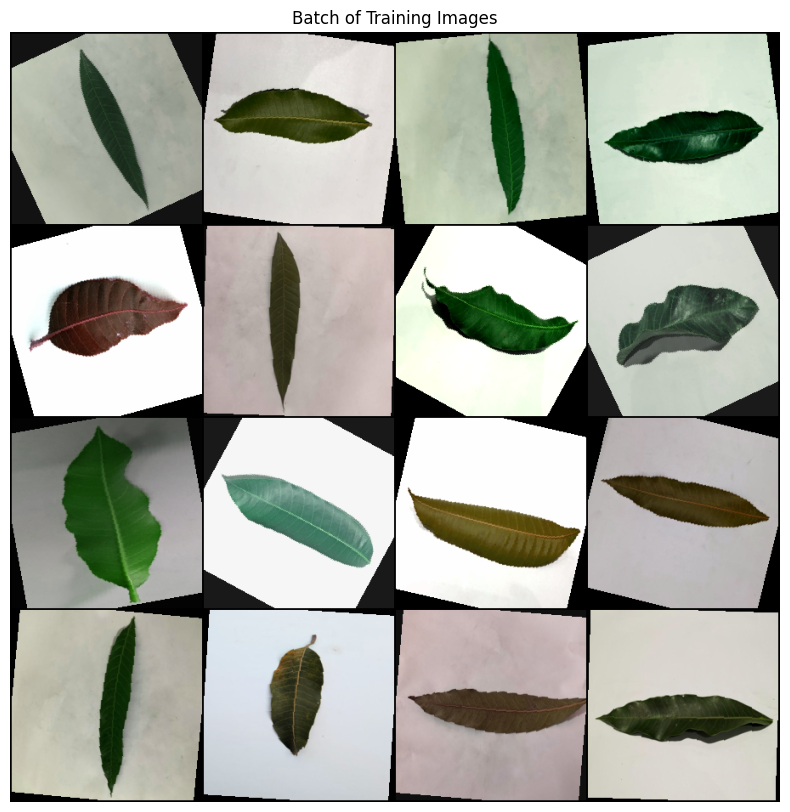

In [10]:
import torchvision
# Visualize a batch of training images
def show_batch(dataloader, title="Batch of Images"):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
show_batch(train_dl, title="Batch of Training Images")

## 3.5 Training the Baseline CNN
***

Now, let's train our simple CNN model to establish a baseline performance.

In [11]:
modelv1 = SimpleCNN()

# Define optimizer and loss function
optimiser = torch.optim.Adam(modelv1.parameters(), lr=5e-3)
criterion = torch.nn.CrossEntropyLoss()

# Set the number of epochs
num_epochs = 10

# Train the model
modelv1 = utils.ml.train_model(modelv1,
                  criterion,
                  optimiser,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs,
                  early_stopping=True,
                  patience=5,
                  save_path= Path.cwd() / "my_models" / "sp_03_model_v1.pt",
                  plot_loss=True)


SimpleCNN Training:   0%|          | 0/10 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Batch 0/4:   0%|          | 0/4 [00:00<?, ?it/s]

Training Batch 0/19:   0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def compute_accuracy(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    acc = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device).type(torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            acc += utils.accuracy_score(labels, predicted)

    return acc / len(test_dataloader)


In [ ]:
# Load the best model and evaluate it on the test set
modelv1.load_state_dict(torch.load(Path.cwd() / "my_models" / "sp_03_model_v1.pt"))
test_accuracy = compute_accuracy(modelv1, test_dl)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.2565


In [ ]:
# Prediction on a single image
image_path = Path.cwd() / 'figs' / 'mango_leaf.png'
img = Image.open(image_path)
img = img.resize((160, 160))
img = ts(img)
img = img.unsqueeze(0)  # Add batch dimension
img = img.to(device)

model_v3.eval()
with torch.no_grad():
    output = model_v3(img)
    _, predicted = torch.max(output, 1)
    predicted_class = ds.classes[predicted.item()]

print(f"Predicted class: {predicted_class}")

Predicted class: Chaunsa Mango


# 4. Transfer Learning with Pre-trained Models
***

Now that we have established a baseline with a simple CNN, let's explore how transfer learning can improve our results. We'll use EfficientNet, a state-of-the-art model pre-trained on ImageNet.

## 4.1 Approach 1: Feature Extraction
***

First, we'll implement the feature extraction approach, where we freeze the pre-trained model's weights and only train a new classifier on top.

In [ ]:
import torchvision.models as models
import torch.nn as nn

<img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Exercise 1: Loading a Pre-trained Model**

Complete the following code to:
1. Load a pre-trained EfficientNet-B0 model
2. Freeze all parameters in the feature extraction layers
3. Replace the classifier with a new one suitable for our 6-class mango leaf disease classification task

<img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Hint**: Use `models.efficientnet_b0(weights='IMAGENET1K_V1')` to load the pre-trained model

In [ ]:
# Your code here
model_v3 = None  # Load the pre-trained model

# Freeze the feature extraction layers

# Replace the classifier with a custom one

# Define optimizer and loss function


# Verify your model
student_answer = {
    "model_loaded": model_v3 is not None,
    "model_type": "EfficientNet",
    "feature_extraction": True,  # Did you freeze the feature extraction layers?
    "feature_layer_freezing": True  # Did you correctly freeze the layers?
}
checker.check_exercise(1, student_answer)

<img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> **Solution**:

In [ ]:
# Load the pre-trained model
model_v3 = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Get the number of features in the last layer
n_features = model_v3.classifier[1].in_features

# Freeze all parameters in the features layers
for param in model_v3.features.parameters():
    param.requires_grad = False

# Replace the classifier with a custom one
# The original classifier has a dropout layer followed by a linear layer
# We'll create a more complex one with additional layers
model_v3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_features, 512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 6)  # 6 classes in our dataset
)

# Define loss function and optimizer
criterion_v3 = torch.nn.CrossEntropyLoss()
optimiser_v3 = torch.optim.Adam(model_v3.classifier.parameters(), lr=1e-3)

# Verify that only the classifier parameters require gradients
requires_grad_count = sum(p.requires_grad for p in model_v3.parameters())
print(f"Parameters requiring gradients: {requires_grad_count}")

# Print the model architecture
print(model_v3.classifier)

<img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Exercise 2: Creating Appropriate Data Transformations**

For transfer learning to work effectively, we need to preprocess our images to match the format expected by the pre-trained model. Complete the following code to create appropriate transformations:

1. Create a transformation pipeline for training data with augmentation
2. Create a separate transformation pipeline for validation/test data (without augmentation)
3. Both pipelines should:
   - Resize images to the size expected by EfficientNet (224×224)
   - Convert images to tensors
   - Normalize with ImageNet mean and std values

<img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Hint**: Use `Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` for ImageNet normalization

In [ ]:
# Your code here
# Create transformations for training data
train_transform = None

# Create transformations for validation/test data
test_transform = None

# Verify your transformations
student_answer = {
    "has_transformations": train_transform is not None and test_transform is not None,
    "resize_transform": {
        "expected_size": [224, 224]
    },
    "normalization_transform": {
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225]
    },
    "augmentation_transform": {
        "has_random_transforms": True
    }
}
checker.check_exercise(2, student_answer)

<img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> **Solution**:

In [ ]:
# Create transformations for training data with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0 expects 224×224 images
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(20),  # Data augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Data augmentation
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create transformations for validation/test data (without augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0 expects 224×224 images
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Show examples of transformed images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
img = Image.open(rnd_img)
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis('off')

# Training transform (with augmentation)
img_train = train_transform(img)
img_train_display = img_train.permute(1, 2, 0).numpy()
# Denormalize for display
img_train_display = img_train_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img_train_display = np.clip(img_train_display, 0, 1)
axes[1].imshow(img_train_display)
axes[1].set_title("Train Transform")
axes[1].axis('off')

# Test transform (without augmentation)
img_test = test_transform(img)
img_test_display = img_test.permute(1, 2, 0).numpy()
# Denormalize for display
img_test_display = img_test_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img_test_display = np.clip(img_test_display, 0, 1)
axes[2].imshow(img_test_display)
axes[2].set_title("Test Transform")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Recreate the datasets with the appropriate transformations
train_dataset = ImageFolder(dataset_path, transform=train_transform)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(
    train_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Override transforms for validation and test sets
val_ds.dataset.transform = test_transform
test_ds.dataset.transform = test_transform

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

<img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Exercise 3: Configure the Transfer Learning Model**

Now that we have our data and model structure set up, let's configure the model for training. Complete the following code to:

1. Create an appropriate classifier head for the feature extraction model
2. Set up an appropriate optimizer for training only the classifier layers
3. Define an appropriate loss function for our multi-class classification task

<img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Hint**: Use a smaller learning rate than you would for training from scratch

In [ ]:
# Your code here

# 1. Define a custom classifier that includes dropout for regularization

# 2. Set up an optimizer that trains only the classifier parameters

# 3. Define the loss function


# Verify your setup
student_answer = {
    "classifier_layers": {
        "expected": True,
        "has_dropout": True,
        "output_classes": True
    },
    "optimizer_config": {
        "optimizer_type": "Adam",
        "learning_rate": {"min": 1e-5, "max": 1e-2}
    },
    "loss_function": {
        "expected_type": "CrossEntropyLoss"
    }
}
checker.check_exercise(3, student_answer)

<img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> **Solution**:

In [ ]:
# Make sure we start with a fresh pre-trained model
model_v3 = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Freeze all parameters in the features layers
for param in model_v3.features.parameters():
    param.requires_grad = False

# Get the number of input features for the classifier
n_features = model_v3.classifier[1].in_features

# 1. Define a custom classifier that includes dropout for regularization
model_v3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),  # First dropout layer for regularization
    torch.nn.Linear(n_features, 512),  # Intermediate layer
    torch.nn.ReLU(inplace=True),  # Activation function
    torch.nn.Dropout(0.3),  # Second dropout layer
    torch.nn.Linear(512, 6)  # Output layer for 6 classes
)

# 2. Set up an optimizer that trains only the classifier parameters
# We use Adam optimizer with a small learning rate for transfer learning
optimizer = torch.optim.Adam(model_v3.classifier.parameters(), lr=3e-4)

# 3. Define the loss function for multi-class classification
criterion = torch.nn.CrossEntropyLoss()

# Print the classifier architecture
print("Classifier architecture:")
print(model_v3.classifier)

# Print the number of trainable parameters
trainable_params = sum(p.numel() for p in model_v3.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_v3.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")
print(f"Total parameters: {total_params:,}")

## 4.2 Training the Feature Extraction Model
***

Now that we have set up our model with feature extraction, let's train it and evaluate its performance.

In [ ]:
# Define the number of epochs for training
num_epochs = 20

# Train the model
model_v3 = utils.train_model(model_v3,
                  criterion,
                  optimizer,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs,
                  early_stopping=True,
                  tolerance=0.01,
                  patience=5,
                  save_path=Path.cwd() / "my_models" / "model_fe.pt",
                  plot_loss=True)

<img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Exercise 4: Evaluate the Feature Extraction Model**

Now that our feature extraction model is trained, let's evaluate its performance on the test set. Complete the following code to:

1. Load the best saved model
2. Calculate accuracy on the test set
3. Compare the results with the baseline CNN model

<img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Hint**: Use the `compute_accuracy` function we defined earlier

In [ ]:
# Your code here

# 1. Load the best model

# 2. Compute accuracy on the test set
feature_extraction_accuracy = 0  # Replace with actual accuracy calculation

# 3. Compare with baseline model

# Verify your evaluation
student_answer = {
    "feature_extraction_accuracy": feature_extraction_accuracy,
    "training_trend": True,
    "early_stopping": True
}
checker.check_exercise(4, student_answer)

<img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> **Solution**:

In [ ]:
# 1. Load the best saved model
model_v3.load_state_dict(torch.load(Path.cwd() / "my_models" / "model_fe.pt"))

# 2. Calculate accuracy on the test set
feature_extraction_accuracy = compute_accuracy(model_v3, test_dl)
print(f"Feature extraction model test accuracy: {feature_extraction_accuracy:.4f}")

# 3. Compare with the baseline model
baseline_accuracy = compute_accuracy(modelv1, test_dl)
print(f"Baseline model test accuracy: {baseline_accuracy:.4f}")

# Calculate improvement
improvement = feature_extraction_accuracy - baseline_accuracy
improvement_percentage = (improvement / baseline_accuracy) * 100
print(f"Improvement: {improvement:.4f} ({improvement_percentage:.2f}%)")

# Create a bar chart to visualize the comparison
plt.figure(figsize=(10, 6))
models = ['Baseline CNN', 'Transfer Learning\n(Feature Extraction)']
accuracies = [baseline_accuracy, feature_extraction_accuracy]
bars = plt.bar(models, accuracies, color=['lightblue', 'lightgreen'])

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f"{height:.4f}", ha='center', va='bottom')

plt.title('Model Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)  # Set y-axis limit from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v3.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v3(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with seaborn for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 5. Fine-tuning Approach
***

Now, let's explore the fine-tuning approach to transfer learning, where we allow some layers of the pre-trained model to be updated during training.

## 5.1 Approach 2: Fine-tuning the Model
***

In this approach, we'll unfreeze the later layers of the model and train them with a smaller learning rate.

<img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Exercise 5: Fine-tuning the Pre-trained Model**

Complete the following code to implement the fine-tuning approach:

1. Load a fresh pre-trained model
2. Freeze early layers but unfreeze some later layers of the feature extractor
3. Replace the classifier with a custom one
4. Set up an optimizer with a smaller learning rate
5. Train the model

<img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Hint**: Use an even smaller learning rate for fine-tuning compared to feature extraction

In [ ]:
# Load a fresh pre-trained model
model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Display the model structure to understand its layers
print("Model structure:")
for i, layer in enumerate(model_ft.features):
    print(f"Layer {i}: {layer.__class__.__name__}")

In [ ]:
# Your code here

# 1. Freeze early layers but unfreeze some later layers

# 2. Replace the classifier

# 3. Create optimizer with smaller learning rate

# 4. Define loss function


# Verify your setup
student_answer = {
    "fine_tuning_implemented": True,
    "selective_unfreezing": True
}
checker.check_exercise(5, student_answer)

<img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> **Solution**:

In [ ]:
# Load a fresh pre-trained model
model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1')

# 1. First freeze all parameters
for param in model_ft.parameters():
    param.requires_grad = False
    
# 2. Then selectively unfreeze later layers
# For EfficientNet, we'll unfreeze the last 3 layers of the feature extractor
for layer in model_ft.features[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

# 3. Replace the classifier
n_features = model_ft.classifier[1].in_features
model_ft.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.4),
    torch.nn.Linear(n_features, 512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 6)  # 6 classes
)

# 4. Create optimizer with smaller learning rate
# We use different learning rates for fine-tuned layers and new classifier layers
params_to_update = []
# Parameters with higher learning rate (new classifier)
classifier_params = {"params": model_ft.classifier.parameters(), "lr": 1e-4}
params_to_update.append(classifier_params)
# Parameters with lower learning rate (fine-tuned layers)
feature_params = {"params": model_ft.features[-3:].parameters(), "lr": 5e-5}
params_to_update.append(feature_params)

# Create optimizer with parameter groups
optimizer_ft = torch.optim.Adam(params_to_update)

# Define loss function
criterion_ft = torch.nn.CrossEntropyLoss()

# Count trainable parameters
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

In [ ]:
# Train the fine-tuned model
num_epochs_ft = 25
model_ft = utils.train_model(model_ft,
                  criterion_ft,
                  optimizer_ft,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs_ft,
                  early_stopping=True,
                  tolerance=0.005,
                  patience=7,
                  save_path=Path.cwd() / "my_models" / "model_ft.pt",
                  plot_loss=True)

In [ ]:
# Load the best fine-tuned model
model_ft.load_state_dict(torch.load(Path.cwd() / "my_models" / "model_ft.pt"))

# Evaluate accuracy on test set
fine_tuning_accuracy = compute_accuracy(model_ft, test_dl)
print(f"Fine-tuning model test accuracy: {fine_tuning_accuracy:.4f}")

# Compare all models
baseline_accuracy = compute_accuracy(modelv1, test_dl)
feature_extraction_accuracy = compute_accuracy(model_v3, test_dl)

# Create a bar chart to visualize the comparison
plt.figure(figsize=(12, 6))
models = ['Baseline CNN', 'Feature Extraction', 'Fine Tuning']
accuracies = [baseline_accuracy, feature_extraction_accuracy, fine_tuning_accuracy]
colors = ['lightblue', 'lightgreen', 'lightcoral']
bars = plt.bar(models, accuracies, color=colors)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f"{height:.4f}", ha='center', va='bottom')

plt.title('Model Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)  # Set y-axis limit from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 5.2 Analyzing Fine-tuning Results
***

Let's create a confusion matrix to analyze the fine-tuned model's performance in detail.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with seaborn for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fine-tuned Model')
plt.tight_layout()
plt.show()

student_answer = {"confusion_matrix": True, "fine_tuning_accuracy": fine_tuning_accuracy}
checker.check_exercise(5, student_answer)

## 5.3 Making Predictions on New Images
***

Finally, let's use our fine-tuned model to make predictions on individual images.

In [ ]:
def predict_image(model, image_path, transform, class_names):
    """Make a prediction on a single image"""
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move to device and make prediction
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image_tensor = image_tensor.to(device)
    
    # Set model to evaluation mode and predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class = class_names[predicted_idx.item()]
    
    # Return prediction and probabilities
    return predicted_class, probabilities.cpu().numpy()

In [ ]:
# Make a prediction on a sample image
image_path = Path.cwd() / 'figs' / 'mango_leaf.png'

# Check if the image exists, if not use a random image from the dataset
if not image_path.exists():
    image_path = random.choice(images)
    
# Make prediction with the fine-tuned model
predicted_class, probabilities = predict_image(
    model_ft, image_path, test_transform, train_dataset.classes)

# Display the image and prediction
plt.figure(figsize=(12, 6))

# Display image
plt.subplot(1, 2, 1)
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')

# Display probabilities
plt.subplot(1, 2, 2)
y_pos = range(len(train_dataset.classes))
bars = plt.barh(y_pos, probabilities, align='center', color='skyblue')
plt.yticks(y_pos, train_dataset.classes)
plt.xlabel('Probability')
plt.title('Class Probabilities')

# Highlight the predicted class
predicted_idx = train_dataset.classes.index(predicted_class)
bars[predicted_idx].set_color('red')

# Add probability values
for i, prob in enumerate(probabilities):
    plt.text(prob + 0.01, i, f"{prob:.4f}", va='center')

plt.xlim(0, 1.1)
plt.tight_layout()
plt.show()

# 6. Conclusion
***

In this workshop, we've explored transfer learning techniques for image classification. Here's a summary of what we've learned:

1. **Transfer Learning Basics**: We discussed what transfer learning is and when to use it.
2. **Feature Extraction**: We implemented the feature extraction approach, where we used a pre-trained model as a fixed feature extractor and trained only a new classifier on top.
3. **Fine-Tuning**: We explored fine-tuning, where we allowed some layers of the pre-trained model to be updated during training.
4. **Performance Comparison**: We compared the performance of a simple CNN, a feature extraction model, and a fine-tuned model.

## 6.1 Key Takeaways
***

1. Transfer learning significantly improves model performance, especially with limited training data.
2. Feature extraction is faster and simpler but may not capture task-specific features as well as fine-tuning.
3. Fine-tuning typically provides the best results but requires careful training with appropriate learning rates.
4. Pre-trained models save time and computational resources while achieving better results than models trained from scratch.

## 6.2 Future Directions
***

To further improve your models, consider the following techniques:

1. **Progressive Unfreezing**: Gradually unfreeze more layers during training, starting from the later layers.
2. **Learning Rate Scheduling**: Use techniques like learning rate annealing or cyclic learning rates.
3. **Ensemble Methods**: Combine multiple fine-tuned models for better performance.
4. **Other Architectures**: Try different pre-trained architectures like ResNet, Vision Transformers, or ConvNeXt.
5. **Domain-Specific Pre-training**: If possible, use models pre-trained on domains more similar to your target task.

Remember that transfer learning is a powerful tool that can be applied to many computer vision tasks beyond classification, including object detection, image segmentation, and more.

In [ ]:
# Quiz on More Advanced Transfer Learning Concepts

print("\n🧠 Quiz 2: Feature Extraction vs Fine-Tuning")
quizzer.run_quiz(2)

print("\n🧠 Quiz 3: Pre-trained Model Selection")
quizzer.run_quiz(3)

print("\n🧠 Quiz 4: Transfer Learning Techniques")
quizzer.run_quiz(4)

print("\n🧠 Quiz 5: Learning Rate Selection")
quizzer.run_quiz(5)